In [1]:
import math
import numpy as np
import sympy as sym
import scipy.special
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp2d
%matplotlib inline

In [2]:
# n: number density
n=sym.symbols('n')

In [3]:
# rs: 3D Wigner-Seitz parameter
def n_from_rs(rs):
    return 3./(4*math.pi*rs*rs*rs) # 3D

In [4]:
### Exchange energy per particle
# Carsten A. Ullrich and Zeng-hui Yang, 
# A Brief Compendium of Time-Dependent Density Functional Theory 
# Braz J Phys (2014) 44:154–188, Eq.(34)
axfactor=-(3/4.)*(3/math.pi)**(1/3.)
def ex(n):
    return axfactor*n**(1/3.) # per particle

In [5]:
### Correlation: Chachiyo-Karasiev parametrization
acfactor=(math.log(2.)-1.)/(2.*math.pi**2)
n2invrs=(4.*math.pi/3)**(1/3.)
def ec(n):
    invrs = n2invrs*n**(1/3.) 
    return acfactor*sym.log( 1. + 21.7392245*invrs + 20.4562557*invrs**2 )

In [6]:
def exc(n):
    return ex(n)+ec(n)
np_exc=sym.lambdify(n, exc(n), 'numpy')

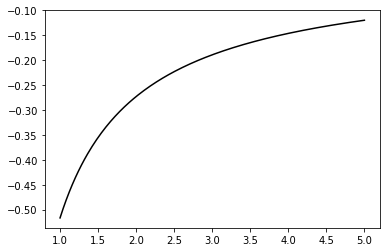

In [7]:
rsrange=np.linspace(1,5,200)
nrange=n_from_rs(rsrange)
fig,ax=plt.subplots()
ax.plot(rsrange,np_exc(nrange),'k')

In [8]:
f0=sym.diff(n*exc(n),n,2) # Eq.(i) GK
#finf=-(4/5.)*n**(2/3.)*sym.diff(exc(n)*n**(-2/3.)) # Eq.(ii) GK
finf=-(4/5.)*n**(2/3.)*sym.diff(exc(n)*n**(-2/3.)) + 6.*n**(1/3.)*sym.diff(exc(n)*n**(-1/3.)) # Eq.(2) Iwamoto
np_f0=sym.lambdify(n, f0, 'numpy')
np_finf=sym.lambdify(n, finf, 'numpy')
np_finf_f0=sym.lambdify(n, finf-f0, 'numpy')

In [9]:
gamma=math.gamma(1/4.)**2/math.sqrt(32*math.pi) # Eq.(17) GK+Errata

In [10]:
c=23*math.pi/15. # GK Eq.(13)

In [11]:
gamma_over_c = gamma/c # from Eq.(13) GK

In [12]:
def Imfxc(n,omega):
    a=-c*(gamma_over_c*np_finf_f0(n))**(5/3.) # GK Eq.(16)+Errata
    b=(gamma_over_c*np_finf_f0(n))**(4/3.) # GK Eq.(17)
    return a*omega/(1.+b*omega*omega)**(5/4.)

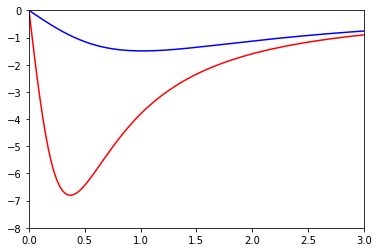

In [13]:
omegarange=np.linspace(0,5,200)
fig,ax=plt.subplots()
#ax.set_xlim([0,5]) # GK
#ax.set_ylim([-2.5,0]) # GK
ax.set_xlim([0,3])# Iwamoto
ax.set_ylim([-8,0]) # Iwamoto
ax.plot(omegarange,Imfxc(n_from_rs(2),omegarange),'b')
ax.plot(omegarange,Imfxc(n_from_rs(4),omegarange),'r')

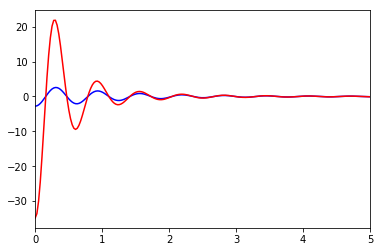

In [14]:
omegarange=np.linspace(0.0001,5,200)
tau=10
fig,ax=plt.subplots()
ax.set_xlim([0,5])
ax.plot(omegarange,Imfxc(n_from_rs(2),omegarange)*np.cos(omegarange*tau)/omegarange,'b')
ax.plot(omegarange,Imfxc(n_from_rs(4),omegarange)*np.cos(omegarange*tau)/omegarange,'r')

In [15]:
def integrand_without_cos(omega,n,tau):
    return Imfxc(n,omega)/omega

In [16]:
def cosintegral(n,tau):
    return 2.*quad(integrand_without_cos,1.e-10,math.inf,args=(n,tau),weight='cos',wvar=tau)[0]

In [17]:
n_from_rs(5)

0.0019098593171027439

In [18]:
n0=1.e-5
n0**(2/3)*cosintegral(n0,1)

-0.9574359368597054

In [19]:
#%timeit cosintegral(n_from_rs(4),1)

In [20]:
def KK_integrand(omega1,n):
    return Imfxc(n,omega1)

def Refxc(n,omega):
    #KKintegral=quad(KK_integrand,-500,500,args=(n,),limit=200,weight='cauchy',wvar=omega,points=[omega])[0]
    KKintegral=quad(KK_integrand,-1000,1000,args=(n,),limit=200,weight='cauchy',wvar=omega,points=[omega])[0]
    return np_finf(n)+KKintegral/math.pi

np_Refxc=np.vectorize(Refxc)

In [21]:
# ### Test: Fig.1 Iwamoto
#omegarange=np.linspace(0,5,20)
#fig,ax=plt.subplots()
# #ax.set_xlim([0,5]) # GK
#ax.set_xlim([0,3]) # Iwamoto
#ax.set_ylim([-17,0])
#ax.plot(omegarange,np_Refxc(n_from_rs(2),omegarange),'b.')
#ax.plot(omegarange,np_Refxc(n_from_rs(4),omegarange),'r.')

In [22]:
nexc2=sym.diff(n*exc(n),n,2)
np_nexc2=sym.lambdify(n, nexc2, 'numpy')

In [23]:
def muxc(n):
    return (3/4.)*n*n*(Refxc(n,0)-np_nexc2(n))

In [24]:
### ykernel: Y/n**2
def ykernel(n,tau):
#    return (3/4.)*(Refxc(n,0)-np_nexc2(n))-cosintegral(n,tau)/math.pi
    return -cosintegral(n,tau)/math.pi
np_y=np.vectorize(ykernel)

In [25]:
Y0=-(20/3.)*n*exc(n)+(26/5.)*n*sym.diff(n*exc(n))-n*n*sym.diff(n*exc(n),n,2)
np_Y0=sym.lambdify(n, Y0, 'numpy')

In [26]:
np_Y0(n_from_rs(4))

0.00016748743915599284

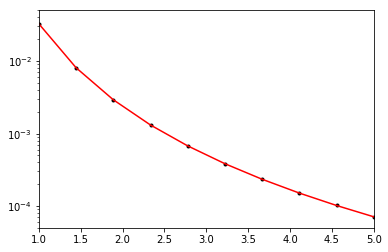

In [27]:
rsrange=np.linspace(1,5,10)
nrange=n_from_rs(rsrange)
fig,ax=plt.subplots()
ax.set_xlim([1,5])
ax.set_ylim([5e-5,5e-2])
ax.semilogy(rsrange,nrange**2*np_y(nrange,0),'k.')
ax.semilogy(rsrange,np_Y0(nrange),'r')

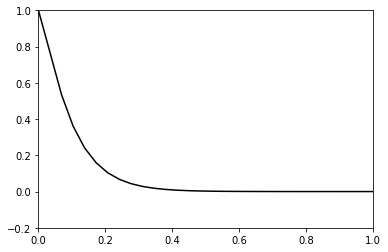

In [28]:
def Tp(n):
    omegap=math.sqrt(4.*math.pi*n)
    return 2.*math.pi/omegap
    #return 0.5*2.*math.pi/omegap # agrees better ???

rs0=5.
n0=n_from_rs(rs0)
tau=np.linspace(0.,Tp(n0),30)
fig,ax=plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(-0.2,1)
ax.plot(tau/Tp(n0),np_y(n0,tau)/np_y(n0,0),'k');

## Two qwell mode

In [29]:
N=1.; L=10.; avomp=math.sqrt(32*N/(math.pi*L)); # Eq.(57) Ullrich

In [30]:
A=2; omega=1*avomp; T=2*math.pi/omega;

In [31]:
def v(xi,t):
    return A*omega*xi*np.cos(omega*t)

def gradv(t):
    return A*omega*np.cos(omega*t)

# def nbreather(x,t):
#     sqrtavg=1./(1+A*np.sin(omega*t))
#     if abs(x)<=(L/2.)*(1+A*np.sin(omega*t)):
#         return (2.*N/L)*sqrtavg*np.cos(sqrtavg*math.pi*x/L)**2
#     else:
#         return 0.

# x -- 1D numpy array
def nbreather(x,t):
    sqrtavg=1./(1+A*np.sin(omega*t))
    inds=np.where(abs(x)<=0.5*L*(1+A*np.sin(omega*t)))
    result=np.zeros_like(x)
    result[inds]=(2.*N/L)*sqrtavg*np.cos(sqrtavg*math.pi*x[inds]/L)**2
    return result

In [32]:
#def nr(x,t):
 #   return 2.*(N/L)*np.cos(math.pi*x/L)**2*(A*np.sin(omega*t)*np.sin(math.pi*x/L))+2.*(N/L)*np.sin(math.pi*x/L)**2*(A*np.cos(omega*t)*np.sin(math.pi*x/L))+0.1


In [33]:
#def nr(x,t):
 #   f=(2.*(N/L)*np.cos(math.pi*x/L)**2*np.cos(omega*t)**2+(2.*(N/L)*np.cos(math.pi*(x+5)/L)**2)*np.sin(omega*t)**2)
  #  return f

In [34]:
#def nr(x,t):
 #   return 2.*(N/L)*A*(np.cos(math.pi*x/L)**2*np.sin(omega*t/3)**2+np.cos(math.pi*x/L)**2/A)*np.heaviside(5-x, 5000)+2.*(N/L)*A*(np.cos(math.pi*(x+10)/L)**2*np.sin(omega*(3/4*T-t)/3)**2+np.cos(math.pi*(x+10)/L)**2/A)*np.heaviside(x-5, 5000)




В качестве плотности сначала возьмем функцию 
$$
n(x,t)=A\cos(\pi x/L)\sin(\omega t/3)\theta(5-x)+A\cos(\pi (x-10)/L)\sin(\omega (3/4T-t)/3)\theta(x-5)
$$

In [35]:
def g(t):
    return (A*np.sin(omega*t/3)**2)
def g_dif(t):
    return (A*np.sin(omega*t/3)*2*np.cos(omega*t/3)*omega/3)
def f(x):
    return np.cos(math.pi*x/L)**2
def nr(x,t):
    return f(x)*g(t)*np.heaviside(5-x, 5000)+f(x-10)*g(3/4*T-t)*np.heaviside(x-5, 5000)

In [36]:
#def nr(x,t):
 #   return f(x)*g(t)+f(x-10)*g(t)

-0.2

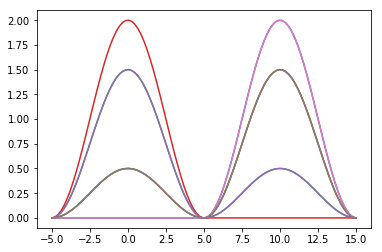

In [37]:
nmax=2*N/L/(1.-A)
xrange=np.linspace(-5,15,100)
fig,ax=plt.subplots()
#ax.set_xlim([-(1+A)*L/2,(1+A)*L/2])
#ax.set_ylim([0,10])
ax.plot(xrange,(nr(xrange,0)))
ax.plot(xrange,(nr(xrange,1*T/4)))
ax.plot(xrange,(nr(xrange,2*T/4)))
ax.plot(xrange,(nr(xrange,3*T/4)))
ax.plot(xrange,(nr(xrange,4*T/4)))
ax.plot(xrange,(nr(xrange,5*T/4)))
ax.plot(xrange,(nr(xrange,6*T/4)))
ax.plot(xrange,(nr(xrange,7*T/4)))
nmax

In [38]:
#B=np.zeros((50))
#from scipy import integrate
#x2 = lambda x: f(x)
#x=np.linspace(-5, 5, 50) 
#for n in range (0,50):
#    B[n]=integrate.quad(x2, 0, x[n])[0]

In [39]:
def Int_n_l(x):
    return (2*math.pi*x/L+np.sin(2*math.pi*x/L))/(4*math.pi/L)
def ww_l(x):
    return Int_n_l(x)/f(x)
def v_l(x,t):
    return -g_dif(t)/g(t)*ww_l(x)

Для такой плотности скорость обращается на концах в бесконечность.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


-0.2

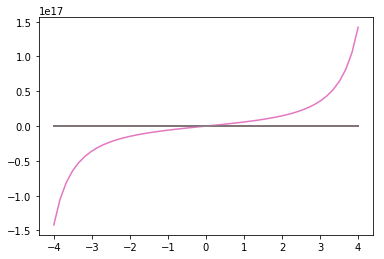

In [40]:
nmax=2*N/L/(1.-A)
xrange=np.linspace(-4,4,50)
fig,ax=plt.subplots()
#ax.set_xlim([-(1+A)*L/2,(1+A)*L/2])
#ax.set_ylim([0,10])
ax.plot(xrange,(v_l(xrange,0)))
ax.plot(xrange,(v_l(xrange,1*T/4)))
ax.plot(xrange,(v_l(xrange,2*T/4)))
ax.plot(xrange,(v_l(xrange,3*T/4)))
ax.plot(xrange,(v_l(xrange,4*T/4)))
ax.plot(xrange,(v_l(xrange,5*T/4)))
ax.plot(xrange,(v_l(xrange,6*T/4)))
ax.plot(xrange,(v_l(xrange,7*T/4)))
nmax

In [41]:
def Int_n_r(x):
    return (2*math.pi*(x-10)/L+np.sin(2*math.pi*(x-10)/L))/(4*math.pi/L)
def ww_r(x):
    return Int_n_r(x)/f(x-10)
def v_r(x,t):
    return g_dif(3/4*T-t)/g(3/4*T-t)*ww_r(x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


-0.2

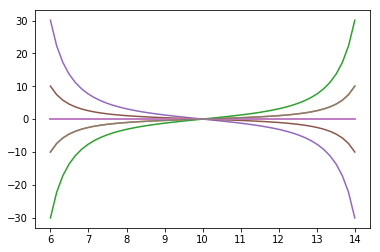

In [42]:
nmax=2*N/L/(1.-A)
xrange=np.linspace(6,14,50)
fig,ax=plt.subplots()
#ax.set_xlim([-(1+A)*L/2,(1+A)*L/2])
#ax.set_ylim([0,10])
ax.plot(xrange,(v_r(xrange,0)))
ax.plot(xrange,(v_r(xrange,1*T/4)))
ax.plot(xrange,(v_r(xrange,2*T/4)))
ax.plot(xrange,(v_r(xrange,3*T/4)))
ax.plot(xrange,(v_r(xrange,4*T/4)))
ax.plot(xrange,(v_r(xrange,5*T/4)))
ax.plot(xrange,(v_r(xrange,6*T/4)))
ax.plot(xrange,(v_r(xrange,7*T/4)))
nmax

Поэтому возьмем в качестве плотности другую функцию - "экспоненциальную шапочку":
$$
e^{\frac{1}{x(x-1)}}
$$
Опять при построении плотности будем использовать кусочную функцию, задаваемую функцией Хевисайда.
Эта "шапочка" медленне, чем $\cos$ и $\sin$ обращается в ноль на концах.
Тем не менее, скорость все равно на концах уходит на бесконечность.
Чтобы избежать этого проделуем следующее.
Во-первых, растянем функцию вдоль оси икс и сдвинем место склейки в ноль. 
Во-вторых, по-отдельности сдвинем две "шапочки" ближе к нулю.
В-третьих, с краев отступим по 0.5.
Построим эту функцию


In [43]:
def g(t):
    return (A*np.sin(omega*t/3)**2+1)
def g_dif(t):
    return (A*np.sin(omega*t/3)*2*np.cos(omega*t/3)*omega/3)
def f(x):
    return np.exp(1/(x)/((x)-1))
def nr(x,t):
    return f(1/10*(x-1)+1)*g(t)*np.heaviside(-x, 5000)+f(1/10*(x+1))*g(3/4*T-t)*np.heaviside(x, 5000)

-0.2

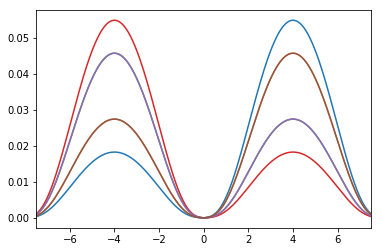

In [44]:
nmax=2*N/L/(1.-A)
xrange=np.linspace(-7.5,7.5,400)
fig,ax=plt.subplots()
#ax.set_xlim([-(1+A)*L/2,(1+A)*L/2])
ax.set_xlim([-7.5,7.5])
ax.plot(xrange,(nr(xrange,0)))
ax.plot(xrange,(nr(xrange,1*T/4)))
ax.plot(xrange,(nr(xrange,2*T/4)))
ax.plot(xrange,(nr(xrange,3*T/4)))
ax.plot(xrange,(nr(xrange,4*T/4)))
ax.plot(xrange,(nr(xrange,5*T/4)))
#ax.plot(xrange,(nr(xrange,6*T/4)))
#ax.plot(xrange,(nr(xrange,7*T/4)))
#ax.plot(xrange,(nr(xrange,8*T/4)))
#ax.plot(xrange,(nr(xrange,9*T/4)))
#ax.plot(xrange,(nr(xrange,10*T/4)))
nmax

Теперь построим скорость

In [45]:
N=100

In [46]:
B_l=np.zeros((N))
from scipy import integrate
x2 = lambda x: f(1/10*(x-1)+1)
x=np.linspace(-8, 0, N) 
for n in range (0,N):
    B_l[n]=integrate.quad(x2, 0, x[n])[0]

In [47]:
w_l=np.zeros((N))
for n in range (0,N):
    w_l[n]=B_l[n]/f(1/10*(x[n]-1)+1)
def v_l(t,n):
    return -g_dif(t)/g(t)*w_l[n]

In [48]:
B_r=np.zeros((N))
from scipy import integrate
x2 = lambda x: f(1/10*(x+1))
x=np.linspace(0, 8, N) 
for n in range (0,N):
    B_r[n]=integrate.quad(x2, 0, x[n])[0]

In [49]:
w_r=np.zeros((N))
for n in range (0,N):
    w_r[n]=B_r[n]/f(1/10*(x[n]+1))
def v_r(t,n):
    return g_dif(3/4*T-t)/g(3/4*T-t)*w_r[n]

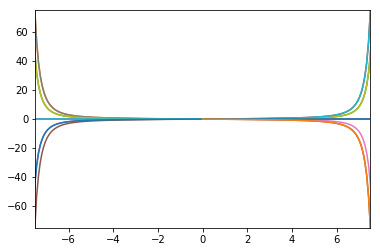

In [50]:
l=list(range(0, N))
x=np.linspace(-8, 0, N) 

fig,ax=plt.subplots()
ax.set_xlim([-7.5,0])
ax.set_ylim([-200,200])
ax.plot(x[l],(v_l(0*T/4, l)))
ax.plot(x[l],(v_l(1*T/4, l)))
ax.plot(x[l],(v_l(2*T/4, l)))
ax.plot(x[l],(v_l(3*T/4, l)))
ax.plot(x[l],(v_l(4*T/4, l)))
ax.plot(x[l],(v_l(5*T/4, l)))
ax.plot(x[l],(v_l(6*T/4, l)))
ax.plot(x[l],(v_l(7*T/4, l)))
ax.plot(x[l],(v_l(8*T/4, l)))
ax.plot(x[l],(v_l(9*T/4, l)))
ax.plot(x[l],(v_l(10*T/4, l)))



l=list(range(0, N-1))

x=np.linspace(0, 8, N) 

ax.set_xlim([-7.5,7.5])
ax.set_ylim([-75,75])
#ax.set_xlim([-7.5,7.5])
#ax.set_ylim([-150,150])
ax.plot(x[l],(v_r(0*T/4, l)))
ax.plot(x[l],(v_r(1*T/4, l)))
ax.plot(x[l],(v_r(2*T/4, l)))
ax.plot(x[l],(v_r(3*T/4, l)))
ax.plot(x[l],(v_r(4*T/4, l)))
ax.plot(x[l],(v_r(5*T/4, l)))
ax.plot(x[l],(v_r(6*T/4, l)))
ax.plot(x[l],(v_r(7*T/4, l)))
ax.plot(x[l],(v_r(8*T/4, l)))
ax.plot(x[l],(v_r(9*T/4, l)))
ax.plot(x[l],(v_r(10*T/4, l)))



Получается такое распределение скорости.
Интересно, что скорость имеет отличную частоту от плотности.

Далее необходимо считать обменную энергию.
Я еще этим не занималась. 
На этом этапе хочу узнать, насколько разумно то, что я я сделала.
Плотность на концах отрезка все-таки не обращается в ноль, хотя и очень мала.